In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import pickle
import optuna as optuna
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.inspection import permutation_importance
from pandas import read_gbq
import datetime
import pytz

In [12]:
# df = read_gbq(f"""

# SELECT *
# FROM capstone-402105.capstone.cri_compustat_data

# """,project_id='capstone-402105', dialect='standard')

df = pd.read_pickle('cri_compustat_data.pkl')

In [13]:
cols = list(df.columns)

df.sort_values(by='EventDate', inplace=True)
date2022 = datetime.datetime(2022, 1, 1).replace(tzinfo=pytz.UTC)
date2020 = datetime.datetime(2020,1,1).replace(tzinfo=pytz.UTC)
train_df = df[df["EventDate"] < date2020]
validation_df = df[(df["EventDate"] >= date2020) & (df["EventDate"] < date2022)]
test_df = df[df["EventDate"] >= date2022]

In [14]:
train_df = train_df.drop(columns=['CompNo','year','month','StartDate','EventDate','Duration','tic', 'dummy297fin', 'gvkey'])
validation_df = validation_df.drop(columns=['CompNo','year','month','StartDate','EventDate','Duration','tic', 'dummy297fin', 'gvkey'])
test_df = test_df.drop(columns=['CompNo','year','month','StartDate','EventDate','Duration','tic', 'dummy297fin', 'gvkey'])

In [15]:
train_df.columns

Index(['StkIndx', 'STInt', 'dtdlevel', 'dtdtrend', 'liqnonfinlevel',
       'liqnonfintrend', 'ni2talevel', 'ni2tatrend', 'sizelevel', 'sizetrend',
       'm2b', 'sigma', 'liqfinlevel', 'lqfintrend', 'DTDmedianFin',
       'DTDmedianNonFin', 'Default_1', 'Default_3', 'Default_6', 'Default_12',
       'Default_24', 'Default_36', 'Default_60', 'current_ratio',
       'quick_ratio', 'cash_ratio', 'net_working_capital', 'debt_ratio',
       'debt_to_equity_ratio', 'equity_ratio', 'cashflow_to_debt_ratio',
       'net_profit_margin', 'return_on_assets', 'asset_turnover',
       'inventory_turnover', 'days_in_inventory', 'receivables_turnover',
       'day_sales_outstanding', 'working_capital_turnover',
       'price_to_earnings', 'dividend_payout_ratio', 'retention_ratio',
       'gross_margin_ratio', 'operating_profit_margin', 'ebitda_margin',
       'debt_service_coverage_ratio', 'interest_coverage_ratio'],
      dtype='object')

In [16]:
x_train = train_df.drop(['Default_1','Default_3','Default_6','Default_12','Default_24','Default_36','Default_60'], axis=1)
y_train = train_df['Default_12']
x_validation = validation_df.drop(['Default_1','Default_3','Default_6','Default_12','Default_24','Default_36','Default_60'], axis=1)
y_validation = validation_df['Default_12']
x_test = test_df.drop(['Default_1','Default_3','Default_6','Default_12','Default_24','Default_36','Default_60'], axis=1)
y_test = test_df["Default_12"]

In [17]:
x_train.columns

Index(['StkIndx', 'STInt', 'dtdlevel', 'dtdtrend', 'liqnonfinlevel',
       'liqnonfintrend', 'ni2talevel', 'ni2tatrend', 'sizelevel', 'sizetrend',
       'm2b', 'sigma', 'liqfinlevel', 'lqfintrend', 'DTDmedianFin',
       'DTDmedianNonFin', 'current_ratio', 'quick_ratio', 'cash_ratio',
       'net_working_capital', 'debt_ratio', 'debt_to_equity_ratio',
       'equity_ratio', 'cashflow_to_debt_ratio', 'net_profit_margin',
       'return_on_assets', 'asset_turnover', 'inventory_turnover',
       'days_in_inventory', 'receivables_turnover', 'day_sales_outstanding',
       'working_capital_turnover', 'price_to_earnings',
       'dividend_payout_ratio', 'retention_ratio', 'gross_margin_ratio',
       'operating_profit_margin', 'ebitda_margin',
       'debt_service_coverage_ratio', 'interest_coverage_ratio'],
      dtype='object')

In [18]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_validation.shape, y_validation.shape

((1084578, 40), (1084578,), (36537, 40), (36537,), (58299, 40), (58299,))

In [19]:
# mini sample to try:
msk = np.random.rand(len(x_train)) < 0.0001
x_train_sample=x_train[msk]
y_train_sample=y_train[msk]

In [20]:
# WARNING: 2 changes to change evaluation metric
optimisation_metric = "auc" #"accuracy" "recall" "precision" "f1" "auc"
def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'objective': 'binary',
        'metric': 'auc', #"accuracy" "recall" "precision" "f1" "auc"
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        # 'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        # 'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 10.0, log=True),
        'scale_pos_weight': 100,
        'max_depth': trial.suggest_int('max_depth', 2, 256),
        'num_boost_round': trial.suggest_int('num_boost_round', 100, 500),
    }
    
    # full data
    
    gbm = lgb.train(param, lgb.Dataset(x_train, y_train))
    
    preds = gbm.predict(x_validation)
    y_pred_binary = np.round(preds)
    
    auc = roc_auc_score(y_validation, preds)
    accuracy = accuracy_score(y_validation, y_pred_binary)
    recall = recall_score(y_validation, y_pred_binary)
    precision = precision_score(y_validation, y_pred_binary)
    f1 = f1_score(y_validation, y_pred_binary)
    
    #choose the metric you want to optimized
    if optimisation_metric == 'recall': 
        return recall
    elif optimisation_metric == 'precision': 
        return precision
    elif optimisation_metric == 'f1':
        return f1
    elif optimisation_metric == 'auc':
        return auc
    elif optimisation_metric == 'accuracy': 
        return accuracy
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

[I 2023-11-08 10:43:09,347] A new study created in memory with name: no-name-5d429cb4-922c-48c7-9da1-de4d49487bbc
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 10:43:30,229] Trial 0 finished with value: 0.9547406081704001 and parameters: {'num_leaves': 74, 'lambda_l1': 0.0004133508999141653, 'lambda_l2': 4.441102441702332, 'feature_fraction': 0.6474677999022035, 'min_child_samples': 33, 'learning_rate': 5.9087173774276904e-08, 'max_depth': 7, 'num_boost_round': 285}. Best is trial 0 with value: 0.9547406081704001.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 10:43:50,130] Trial 1 finished with value: 0.951529114709964 and parameters: {'num_leaves': 20, 'lambda_l1': 3.3630306941181416e-07, 'lambda_l2': 0.0334715445070849, 'feature_fraction': 0.4917916787818553, 'min_child_samples': 38, 'learning_rate': 2.8634286700641866e-08, 'max_depth': 60, 'num_boost_round': 475}. Best is trial 0 with value: 0.9547406081704001.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 10:44:05,047] Trial 2 finished with value: 0.9599525788549547 and parameters: {'num_leaves': 170, 'lambda_l1': 1.9449982239618413, 'lambda_l2': 3.905339173636238e-06, 'feature_fraction': 0.5337485817709972, 'min_child_samples': 77, 'learning_rate': 7.111622190475277e-07, 'max_depth': 11, 'num_boost_round': 150}. Best is trial 2 with value: 0.9599525788549547.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.129783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 10:44:31,644] Trial 3 finished with value: 0.9537920815725779 and parameters: {'num_leaves': 70, 'lambda_l1': 0.26073832117721296, 'lambda_l2': 2.5200317659145533e-07, 'feature_fraction': 0.8364087159072582, 'min_child_samples': 90, 'learning_rate': 4.087759882739944e-08, 'max_depth': 183, 'num_boost_round': 298}. Best is trial 2 with value: 0.9599525788549547.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.128258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:45:03,374] Trial 4 finished with value: 0.855905659384669 and parameters: {'num_leaves': 138, 'lambda_l1': 0.012095992745652179, 'lambda_l2': 0.16906049309671883, 'feature_fraction': 0.9867863320112477, 'min_child_samples': 99, 'learning_rate': 0.09665965547266704, 'max_depth': 197, 'num_boost_round': 234}. Best is trial 2 with value: 0.9599525788549547.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 10:45:23,909] Trial 5 finished with value: 0.9585922936382271 and parameters: {'num_leaves': 79, 'lambda_l1': 0.0019029331118575322, 'lambda_l2': 1.0367705223620144e-06, 'feature_fraction': 0.7991012732216571, 'min_child_samples': 15, 'learning_rate': 6.270050139297151e-05, 'max_depth': 247, 'num_boost_round': 151}. Best is trial 2 with value: 0.9599525788549547.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.169811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 10:45:48,974] Trial 6 finished with value: 0.9601350581368568 and parameters: {'num_leaves': 79, 'lambda_l1': 7.13866643832071e-07, 'lambda_l2': 1.4412825881352798, 'feature_fraction': 0.6094969344656654, 'min_child_samples': 80, 'learning_rate': 0.0014975634626866042, 'max_depth': 75, 'num_boost_round': 219}. Best is trial 6 with value: 0.9601350581368568.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leave

[I 2023-11-08 10:46:09,169] Trial 7 finished with value: 0.7847723317855932 and parameters: {'num_leaves': 97, 'lambda_l1': 1.10686308582581, 'lambda_l2': 2.7584760540446517e-05, 'feature_fraction': 0.5741304891326023, 'min_child_samples': 38, 'learning_rate': 1.8561236263308534, 'max_depth': 48, 'num_boost_round': 473}. Best is trial 6 with value: 0.9601350581368568.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.188063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 10:47:22,831] Trial 8 finished with value: 0.9480573419926442 and parameters: {'num_leaves': 62, 'lambda_l1': 9.564934300053136e-07, 'lambda_l2': 7.1239563210461805, 'feature_fraction': 0.8962733853086592, 'min_child_samples': 54, 'learning_rate': 1.1339492797423141e-07, 'max_depth': 48, 'num_boost_round': 485}. Best is trial 6 with value: 0.9601350581368568.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 10:48:22,167] Trial 9 finished with value: 0.9585618940689076 and parameters: {'num_leaves': 123, 'lambda_l1': 0.0017606497816638022, 'lambda_l2': 0.00012989063332375208, 'feature_fraction': 0.4382072344335048, 'min_child_samples': 32, 'learning_rate': 1.3109717157698524e-06, 'max_depth': 130, 'num_boost_round': 391}. Best is trial 6 with value: 0.9601350581368568.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:49:12,528] Trial 10 finished with value: 0.9660526863286206 and parameters: {'num_leaves': 231, 'lambda_l1': 1.0235117450213365e-08, 'lambda_l2': 0.002028670343979259, 'feature_fraction': 0.6915029860713431, 'min_child_samples': 68, 'learning_rate': 0.003392360235074482, 'max_depth': 118, 'num_boost_round': 214}. Best is trial 10 with value: 0.9660526863286206.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.173111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 10:50:18,371] Trial 11 finished with value: 0.9635415563749916 and parameters: {'num_leaves': 253, 'lambda_l1': 2.3629710907507974e-08, 'lambda_l2': 0.0032003115416872146, 'feature_fraction': 0.7089569637872839, 'min_child_samples': 67, 'learning_rate': 0.0017984793945759706, 'max_depth': 111, 'num_boost_round': 216}. Best is trial 10 with value: 0.9660526863286206.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.236420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 10:51:25,208] Trial 12 finished with value: 0.9633429494939263 and parameters: {'num_leaves': 250, 'lambda_l1': 1.2279873119123126e-08, 'lambda_l2': 0.0034034148366769612, 'feature_fraction': 0.7212658202085601, 'min_child_samples': 62, 'learning_rate': 0.0015728048527824713, 'max_depth': 117, 'num_boost_round': 216}. Best is trial 10 with value: 0.9660526863286206.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:51:56,956] Trial 13 finished with value: 0.9670620393537434 and parameters: {'num_leaves': 249, 'lambda_l1': 1.6670321343197563e-08, 'lambda_l2': 0.001616402829547298, 'feature_fraction': 0.7066351610017283, 'min_child_samples': 69, 'learning_rate': 0.023434854241698562, 'max_depth': 118, 'num_boost_round': 136}. Best is trial 13 with value: 0.9670620393537434.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:52:22,285] Trial 14 finished with value: 0.9512527897199027 and parameters: {'num_leaves': 210, 'lambda_l1': 2.849642625846646e-05, 'lambda_l2': 0.0008451165935548583, 'feature_fraction': 0.6636570607118715, 'min_child_samples': 71, 'learning_rate': 0.06655661546937285, 'max_depth': 158, 'num_boost_round': 108}. Best is trial 13 with value: 0.9670620393537434.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 10:52:54,304] Trial 15 finished with value: 0.9607417123788138 and parameters: {'num_leaves': 196, 'lambda_l1': 1.3578242466518698e-05, 'lambda_l2': 1.0277746238462492e-08, 'feature_fraction': 0.7736236344857441, 'min_child_samples': 52, 'learning_rate': 6.518148508831892e-05, 'max_depth': 93, 'num_boost_round': 158}. Best is trial 13 with value: 0.9670620393537434.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.183716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split require

[I 2023-11-08 10:53:09,795] Trial 16 finished with value: 0.7341700382718025 and parameters: {'num_leaves': 218, 'lambda_l1': 1.2734343059819376e-08, 'lambda_l2': 0.023965522293622, 'feature_fraction': 0.6071792983856734, 'min_child_samples': 86, 'learning_rate': 7.1960693957056, 'max_depth': 157, 'num_boost_round': 359}. Best is trial 13 with value: 0.9670620393537434.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:53:59,692] Trial 17 finished with value: 0.9484972352219342 and parameters: {'num_leaves': 171, 'lambda_l1': 1.461254105475161e-07, 'lambda_l2': 0.00024546960667929204, 'feature_fraction': 0.734383205031809, 'min_child_samples': 53, 'learning_rate': 0.06939147492513942, 'max_depth': 145, 'num_boost_round': 267}. Best is trial 13 with value: 0.9670620393537434.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.184580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:54:34,189] Trial 18 finished with value: 0.9643738332732619 and parameters: {'num_leaves': 229, 'lambda_l1': 7.369446417021595e-06, 'lambda_l2': 0.0018814793074975779, 'feature_fraction': 0.6526360067165318, 'min_child_samples': 7, 'learning_rate': 0.011646509321458257, 'max_depth': 215, 'num_boost_round': 122}. Best is trial 13 with value: 0.9670620393537434.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.251298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No

[I 2023-11-08 10:54:54,401] Trial 19 finished with value: 0.5550471253359507 and parameters: {'num_leaves': 185, 'lambda_l1': 7.415728150104785e-08, 'lambda_l2': 5.616659313972679e-05, 'feature_fraction': 0.6859978367096086, 'min_child_samples': 100, 'learning_rate': 0.6223469076340493, 'max_depth': 81, 'num_boost_round': 186}. Best is trial 13 with value: 0.9670620393537434.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.189643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 10:56:41,190] Trial 20 finished with value: 0.9614799525482917 and parameters: {'num_leaves': 232, 'lambda_l1': 1.695488692877869e-06, 'lambda_l2': 0.018408930179577686, 'feature_fraction': 0.7686399306646915, 'min_child_samples': 63, 'learning_rate': 9.011408737190131e-05, 'max_depth': 99, 'num_boost_round': 350}. Best is trial 13 with value: 0.9670620393537434.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.189714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:57:10,725] Trial 21 finished with value: 0.9638292334483896 and parameters: {'num_leaves': 234, 'lambda_l1': 6.977612105917926e-08, 'lambda_l2': 0.0020092026753157207, 'feature_fraction': 0.6505512826418344, 'min_child_samples': 12, 'learning_rate': 0.008352935186850147, 'max_depth': 236, 'num_boost_round': 109}. Best is trial 13 with value: 0.9670620393537434.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.190489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:57:36,853] Trial 22 finished with value: 0.9643369117137564 and parameters: {'num_leaves': 214, 'lambda_l1': 6.3202918675354905e-06, 'lambda_l2': 0.0005706623492383819, 'feature_fraction': 0.5906077175614145, 'min_child_samples': 6, 'learning_rate': 0.014527715708177272, 'max_depth': 213, 'num_boost_round': 104}. Best is trial 13 with value: 0.9670620393537434.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:58:37,675] Trial 23 finished with value: 0.9652981821166701 and parameters: {'num_leaves': 237, 'lambda_l1': 1.4618374429362445e-07, 'lambda_l2': 0.0041542330365018955, 'feature_fraction': 0.678636893405579, 'min_child_samples': 48, 'learning_rate': 0.0094239077559596, 'max_depth': 178, 'num_boost_round': 183}. Best is trial 13 with value: 0.9670620393537434.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.167940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 10:59:14,253] Trial 24 finished with value: 0.9606370330718934 and parameters: {'num_leaves': 153, 'lambda_l1': 9.45391025269624e-08, 'lambda_l2': 0.009595214615195281, 'feature_fraction': 0.7266571208009627, 'min_child_samples': 47, 'learning_rate': 0.0003337486831215962, 'max_depth': 180, 'num_boost_round': 181}. Best is trial 13 with value: 0.9670620393537434.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-11-08 11:00:09,548] Trial 25 finished with value: 0.7426670453605236 and parameters: {'num_leaves': 252, 'lambda_l1': 1.9897499836889803e-08, 'lambda_l2': 0.3178137396550525, 'feature_fraction': 0.6906053495649078, 'min_child_samples': 71, 'learning_rate': 0.30166510855845186, 'max_depth': 144, 'num_boost_round': 251}. Best is trial 13 with value: 0.9670620393537434.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:00:44,769] Trial 26 finished with value: 0.9719927185117768 and parameters: {'num_leaves': 196, 'lambda_l1': 3.038688243745638e-07, 'lambda_l2': 0.0003902476757939909, 'feature_fraction': 0.554982579436186, 'min_child_samples': 59, 'learning_rate': 0.038262849648605435, 'max_depth': 131, 'num_boost_round': 188}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.167114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-11-08 11:01:16,767] Trial 27 finished with value: 0.7896279944121553 and parameters: {'num_leaves': 195, 'lambda_l1': 1.1782862583240358e-08, 'lambda_l2': 0.00039575166501161626, 'feature_fraction': 0.5230080933757791, 'min_child_samples': 60, 'learning_rate': 0.292627654023585, 'max_depth': 126, 'num_boost_round': 324}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:01:47,982] Trial 28 finished with value: 0.965833067177918 and parameters: {'num_leaves': 204, 'lambda_l1': 4.4193320125235097e-07, 'lambda_l2': 5.040155580715993e-05, 'feature_fraction': 0.4159824558885836, 'min_child_samples': 78, 'learning_rate': 0.04889337266411186, 'max_depth': 107, 'num_boost_round': 195}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.220978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No

[I 2023-11-08 11:02:02,492] Trial 29 finished with value: 0.6729141965879567 and parameters: {'num_leaves': 180, 'lambda_l1': 2.2673497277097267e-06, 'lambda_l2': 0.08143713447656106, 'feature_fraction': 0.6313842975953652, 'min_child_samples': 87, 'learning_rate': 1.3758345956915246, 'max_depth': 136, 'num_boost_round': 271}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leave

[I 2023-11-08 11:02:09,240] Trial 30 finished with value: 0.5025727204634619 and parameters: {'num_leaves': 155, 'lambda_l1': 3.505533690676011e-08, 'lambda_l2': 0.008997587802459246, 'feature_fraction': 0.5638186731553371, 'min_child_samples': 24, 'learning_rate': 9.704490553773509, 'max_depth': 161, 'num_boost_round': 141}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.128212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:02:37,864] Trial 31 finished with value: 0.9693214859789764 and parameters: {'num_leaves': 204, 'lambda_l1': 3.68938107864197e-07, 'lambda_l2': 3.154190235158219e-05, 'feature_fraction': 0.41551173247880546, 'min_child_samples': 77, 'learning_rate': 0.03352808820806277, 'max_depth': 111, 'num_boost_round': 185}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.169710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-11-08 11:03:04,749] Trial 32 finished with value: 0.8311176486255137 and parameters: {'num_leaves': 219, 'lambda_l1': 2.13401544710319e-07, 'lambda_l2': 0.00016530975639327997, 'feature_fraction': 0.47236714390002893, 'min_child_samples': 72, 'learning_rate': 0.20572008466840547, 'max_depth': 82, 'num_boost_round': 166}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.162014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:03:32,443] Trial 33 finished with value: 0.9680635878215724 and parameters: {'num_leaves': 241, 'lambda_l1': 3.1351016299298547e-07, 'lambda_l2': 1.4138212823521331e-05, 'feature_fraction': 0.4739817918843753, 'min_child_samples': 83, 'learning_rate': 0.033200945894732596, 'max_depth': 62, 'num_boost_round': 137}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:03:43,803] Trial 34 finished with value: 0.9681122162170186 and parameters: {'num_leaves': 36, 'lambda_l1': 3.442728995781863e-07, 'lambda_l2': 1.0624586870973674e-05, 'feature_fraction': 0.4918760695089961, 'min_child_samples': 93, 'learning_rate': 0.02722565817030842, 'max_depth': 26, 'num_boost_round': 133}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:04:01,158] Trial 35 finished with value: 0.9690532384328274 and parameters: {'num_leaves': 41, 'lambda_l1': 3.82174422342018e-07, 'lambda_l2': 1.2482118822311089e-05, 'feature_fraction': 0.47809803058422484, 'min_child_samples': 93, 'learning_rate': 0.03425100006204213, 'max_depth': 17, 'num_boost_round': 166}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:04:12,614] Trial 36 finished with value: 0.9711847012339059 and parameters: {'num_leaves': 14, 'lambda_l1': 4.195710283432564e-05, 'lambda_l2': 6.561334147981692e-06, 'feature_fraction': 0.4041795725643329, 'min_child_samples': 93, 'learning_rate': 0.07436190869879268, 'max_depth': 20, 'num_boost_round': 240}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.151562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:04:21,610] Trial 37 finished with value: 0.8497106419450311 and parameters: {'num_leaves': 9, 'lambda_l1': 4.2954593081747215e-05, 'lambda_l2': 4.7649050657445863e-07, 'feature_fraction': 0.4144674980860558, 'min_child_samples': 94, 'learning_rate': 0.1937996442716355, 'max_depth': 7, 'num_boost_round': 247}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:04:41,482] Trial 38 finished with value: 0.9437245028387848 and parameters: {'num_leaves': 37, 'lambda_l1': 8.035351044382142e-05, 'lambda_l2': 5.987070533484276e-06, 'feature_fraction': 0.4002496003576267, 'min_child_samples': 94, 'learning_rate': 0.11503646553893247, 'max_depth': 27, 'num_boost_round': 295}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.151676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leave

[I 2023-11-08 11:04:48,544] Trial 39 finished with value: 0.7859195744191281 and parameters: {'num_leaves': 30, 'lambda_l1': 2.346764636292104e-06, 'lambda_l2': 2.534849380730215e-06, 'feature_fraction': 0.44856087910413417, 'min_child_samples': 78, 'learning_rate': 1.0655331608073717, 'max_depth': 30, 'num_boost_round': 168}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:05:08,344] Trial 40 finished with value: 0.9604155582921838 and parameters: {'num_leaves': 54, 'lambda_l1': 0.0001597613556900343, 'lambda_l2': 2.5963145203476344e-05, 'feature_fraction': 0.5069850033380578, 'min_child_samples': 84, 'learning_rate': 0.0033488486628724234, 'max_depth': 44, 'num_boost_round': 231}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:05:17,207] Trial 41 finished with value: 0.9680645429247376 and parameters: {'num_leaves': 7, 'lambda_l1': 6.330477490085474e-07, 'lambda_l2': 6.149064465147869e-06, 'feature_fraction': 0.4869074640844207, 'min_child_samples': 93, 'learning_rate': 0.04333373726343639, 'max_depth': 21, 'num_boost_round': 197}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.129882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-11-08 11:05:26,517] Trial 42 finished with value: 0.9678161342357657 and parameters: {'num_leaves': 97, 'lambda_l1': 1.0153320386872751e-06, 'lambda_l2': 1.4046869243597861e-05, 'feature_fraction': 0.543841254549639, 'min_child_samples': 91, 'learning_rate': 0.024043526117892323, 'max_depth': 4, 'num_boost_round': 203}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:05:37,668] Trial 43 finished with value: 0.9549436903920115 and parameters: {'num_leaves': 39, 'lambda_l1': 3.894083969174388e-06, 'lambda_l2': 2.399708023548791e-06, 'feature_fraction': 0.4535485451761, 'min_child_samples': 98, 'learning_rate': 0.10544789691652226, 'max_depth': 61, 'num_boost_round': 156}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:05:52,446] Trial 44 finished with value: 0.9606379608863969 and parameters: {'num_leaves': 24, 'lambda_l1': 2.956151614844963e-07, 'lambda_l2': 0.00010933352446721445, 'feature_fraction': 0.5076013935282627, 'min_child_samples': 89, 'learning_rate': 0.005657894810683809, 'max_depth': 16, 'num_boost_round': 230}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:06:03,106] Trial 45 finished with value: 0.8403997232274758 and parameters: {'num_leaves': 52, 'lambda_l1': 7.757889861330041e-07, 'lambda_l2': 6.878522053951581e-05, 'feature_fraction': 0.4344758284032967, 'min_child_samples': 75, 'learning_rate': 0.48822436586644424, 'max_depth': 41, 'num_boost_round': 127}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.226511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:06:26,059] Trial 46 finished with value: 0.9716253039684046 and parameters: {'num_leaves': 122, 'lambda_l1': 1.8566583912005392e-05, 'lambda_l2': 1.2243196884104924e-05, 'feature_fraction': 0.46663471535406964, 'min_child_samples': 83, 'learning_rate': 0.021404090118715077, 'max_depth': 30, 'num_boost_round': 172}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 11:07:19,884] Trial 47 finished with value: 0.9619038273330659 and parameters: {'num_leaves': 117, 'lambda_l1': 1.6899301253632983e-05, 'lambda_l2': 3.585329362557487e-05, 'feature_fraction': 0.4622550291017882, 'min_child_samples': 81, 'learning_rate': 0.0008403848681978544, 'max_depth': 35, 'num_boost_round': 439}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.167575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:07:55,341] Trial 48 finished with value: 0.9645063197266244 and parameters: {'num_leaves': 150, 'lambda_l1': 0.000262593165545955, 'lambda_l2': 1.2764245228442165e-06, 'feature_fraction': 0.43365327121294023, 'min_child_samples': 98, 'learning_rate': 0.003895513987174761, 'max_depth': 69, 'num_boost_round': 248}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:08:13,289] Trial 49 finished with value: 0.8661923114959272 and parameters: {'num_leaves': 114, 'lambda_l1': 7.060196472115328e-06, 'lambda_l2': 0.0002263135494112631, 'feature_fraction': 0.5406134613518749, 'min_child_samples': 76, 'learning_rate': 0.11505911643573635, 'max_depth': 54, 'num_boost_round': 173}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:08:42,661] Trial 50 finished with value: 0.9673941423686603 and parameters: {'num_leaves': 135, 'lambda_l1': 0.000871770199546958, 'lambda_l2': 2.2359596160282883e-05, 'feature_fraction': 0.4261930531777669, 'min_child_samples': 88, 'learning_rate': 0.013816963390759114, 'max_depth': 15, 'num_boost_round': 207}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:08:49,661] Trial 51 finished with value: 0.9677111001762411 and parameters: {'num_leaves': 89, 'lambda_l1': 1.6540981182985536e-06, 'lambda_l2': 8.012269845848527e-06, 'feature_fraction': 0.4881130877884613, 'min_child_samples': 96, 'learning_rate': 0.02311686268648808, 'max_depth': 3, 'num_boost_round': 150}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:08:57,153] Trial 52 finished with value: 0.9675657880518014 and parameters: {'num_leaves': 14, 'lambda_l1': 4.0983196442357427e-07, 'lambda_l2': 1.0282657924528239e-05, 'feature_fraction': 0.4007290128512004, 'min_child_samples': 82, 'learning_rate': 0.05050943960976971, 'max_depth': 23, 'num_boost_round': 123}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:09:14,271] Trial 53 finished with value: 0.9691266722219105 and parameters: {'num_leaves': 74, 'lambda_l1': 4.957315508801674e-08, 'lambda_l2': 3.6312633776744977e-06, 'feature_fraction': 0.45075099729256574, 'min_child_samples': 90, 'learning_rate': 0.024220779143346294, 'max_depth': 33, 'num_boost_round': 156}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.192527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:09:37,081] Trial 54 finished with value: 0.9629556688047152 and parameters: {'num_leaves': 68, 'lambda_l1': 4.119267764318953e-08, 'lambda_l2': 3.3916562476981625e-06, 'feature_fraction': 0.4508935661951049, 'min_child_samples': 86, 'learning_rate': 0.005917153472402529, 'max_depth': 37, 'num_boost_round': 223}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leave

[I 2023-11-08 11:09:45,601] Trial 55 finished with value: 0.8328467673960308 and parameters: {'num_leaves': 86, 'lambda_l1': 6.59981049230528e-08, 'lambda_l2': 0.00012645671912135195, 'feature_fraction': 0.46840983226153543, 'min_child_samples': 39, 'learning_rate': 2.968544659297804, 'max_depth': 49, 'num_boost_round': 185}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2023-11-08 11:09:59,213] Trial 56 finished with value: 0.841191340019565 and parameters: {'num_leaves': 47, 'lambda_l1': 1.8433070485783378e-07, 'lambda_l2': 5.586461425205528e-05, 'feature_fraction': 0.43773035568086827, 'min_child_samples': 65, 'learning_rate': 0.6008788789281894, 'max_depth': 90, 'num_boost_round': 166}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:10:17,078] Trial 57 finished with value: 0.9639568079426161 and parameters: {'num_leaves': 104, 'lambda_l1': 1.9238107500411975e-05, 'lambda_l2': 9.749823589428562e-07, 'feature_fraction': 0.5145304438086703, 'min_child_samples': 58, 'learning_rate': 0.08214841392455735, 'max_depth': 72, 'num_boost_round': 151}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.132546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:10:23,089] Trial 58 finished with value: 0.9534527197736045 and parameters: {'num_leaves': 2, 'lambda_l1': 1.0533694218823177e-06, 'lambda_l2': 2.5026591876309906e-05, 'feature_fraction': 0.4525320482013377, 'min_child_samples': 91, 'learning_rate': 0.014826243212603283, 'max_depth': 11, 'num_boost_round': 195}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 11:10:41,070] Trial 59 finished with value: 0.9561074699546375 and parameters: {'num_leaves': 22, 'lambda_l1': 3.989019233686571e-06, 'lambda_l2': 0.0006387961206969979, 'feature_fraction': 0.40045051806539417, 'min_child_samples': 85, 'learning_rate': 0.0015442403538993349, 'max_depth': 53, 'num_boost_round': 272}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:10:58,186] Trial 60 finished with value: 0.86471902393041 and parameters: {'num_leaves': 73, 'lambda_l1': 3.206510567885941e-08, 'lambda_l2': 4.4568826380793775e-06, 'feature_fraction': 0.4930186590525939, 'min_child_samples': 74, 'learning_rate': 0.18827804485985578, 'max_depth': 169, 'num_boost_round': 215}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:11:11,488] Trial 61 finished with value: 0.9677690612940458 and parameters: {'num_leaves': 37, 'lambda_l1': 1.1592945542059878e-07, 'lambda_l2': 2.441749379423253e-05, 'feature_fraction': 0.49222962743971754, 'min_child_samples': 91, 'learning_rate': 0.01893471642700223, 'max_depth': 30, 'num_boost_round': 142}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:11:24,316] Trial 62 finished with value: 0.9695737150806096 and parameters: {'num_leaves': 62, 'lambda_l1': 3.815107008468498e-07, 'lambda_l2': 1.1568684930404323e-05, 'feature_fraction': 0.5303344754281881, 'min_child_samples': 100, 'learning_rate': 0.03443214666858921, 'max_depth': 19, 'num_boost_round': 117}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.213527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:11:36,489] Trial 63 finished with value: 0.9708553270851759 and parameters: {'num_leaves': 62, 'lambda_l1': 5.916278573624012e-08, 'lambda_l2': 8.770036101633566e-05, 'feature_fraction': 0.5265718040933378, 'min_child_samples': 100, 'learning_rate': 0.04788792296182375, 'max_depth': 195, 'num_boost_round': 113}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:11:51,993] Trial 64 finished with value: 0.9640164336687946 and parameters: {'num_leaves': 64, 'lambda_l1': 5.487718799743334e-08, 'lambda_l2': 0.0003802441592370122, 'feature_fraction': 0.5290114187072535, 'min_child_samples': 100, 'learning_rate': 0.008666452753518477, 'max_depth': 256, 'num_boost_round': 110}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.187065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:12:06,240] Trial 65 finished with value: 0.97100874394219 and parameters: {'num_leaves': 81, 'lambda_l1': 1.5324851973945315e-07, 'lambda_l2': 8.142321041040042e-05, 'feature_fraction': 0.5553509889295227, 'min_child_samples': 98, 'learning_rate': 0.06755124140919647, 'max_depth': 204, 'num_boost_round': 123}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.451164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:36:33,148] Trial 66 finished with value: 0.9637109370991978 and parameters: {'num_leaves': 163, 'lambda_l1': 1.2013774970723382e-07, 'lambda_l2': 0.0001086073506322589, 'feature_fraction': 0.5682347772892843, 'min_child_samples': 97, 'learning_rate': 0.06642635501170274, 'max_depth': 211, 'num_boost_round': 118}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:36:43,698] Trial 67 finished with value: 0.7254029825852493 and parameters: {'num_leaves': 84, 'lambda_l1': 2.32506900679987e-08, 'lambda_l2': 0.0010181923807727514, 'feature_fraction': 0.5495126692415161, 'min_child_samples': 100, 'learning_rate': 0.3964309136761799, 'max_depth': 196, 'num_boost_round': 108}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.188179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:36:56,949] Trial 68 finished with value: 0.9216837781130525 and parameters: {'num_leaves': 58, 'lambda_l1': 9.35719790916199e-06, 'lambda_l2': 6.614263877138943e-05, 'feature_fraction': 0.5960070393353909, 'min_child_samples': 97, 'learning_rate': 0.10260937328632438, 'max_depth': 228, 'num_boost_round': 116}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:37:21,744] Trial 69 finished with value: 0.827760215401415 and parameters: {'num_leaves': 141, 'lambda_l1': 1.3809508859200935e-07, 'lambda_l2': 0.0002443975026300012, 'feature_fraction': 0.5249763664364204, 'min_child_samples': 79, 'learning_rate': 0.2545066631505222, 'max_depth': 192, 'num_boost_round': 179}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:37:39,402] Trial 70 finished with value: 0.9656134207385535 and parameters: {'num_leaves': 106, 'lambda_l1': 2.1283544038284772e-07, 'lambda_l2': 4.056228510570386e-05, 'feature_fraction': 0.5806046361230309, 'min_child_samples': 96, 'learning_rate': 0.01058769248704111, 'max_depth': 224, 'num_boost_round': 101}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:38:02,693] Trial 71 finished with value: 0.9717514321635522 and parameters: {'num_leaves': 126, 'lambda_l1': 6.859125360040701e-08, 'lambda_l2': 5.224116501079397e-06, 'feature_fraction': 0.5076244476669225, 'min_child_samples': 89, 'learning_rate': 0.04345950649020616, 'max_depth': 190, 'num_boost_round': 144}. Best is trial 26 with value: 0.9719927185117768.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.184994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:38:36,204] Trial 72 finished with value: 0.9722785945334916 and parameters: {'num_leaves': 124, 'lambda_l1': 9.002725669456124e-08, 'lambda_l2': 8.470908645797089e-05, 'feature_fraction': 0.5558970857095032, 'min_child_samples': 95, 'learning_rate': 0.04899530623021338, 'max_depth': 201, 'num_boost_round': 132}. Best is trial 72 with value: 0.9722785945334916.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:38:55,603] Trial 73 finished with value: 0.9705678137437489 and parameters: {'num_leaves': 119, 'lambda_l1': 1.774687769490257e-08, 'lambda_l2': 9.017612912710789e-05, 'feature_fraction': 0.5542032202884718, 'min_child_samples': 95, 'learning_rate': 0.04964530945473355, 'max_depth': 190, 'num_boost_round': 131}. Best is trial 72 with value: 0.9722785945334916.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:39:12,117] Trial 74 finished with value: 0.7691559857024877 and parameters: {'num_leaves': 130, 'lambda_l1': 1.7540698344360247e-08, 'lambda_l2': 0.00017342425903397757, 'feature_fraction': 0.5498013722145876, 'min_child_samples': 95, 'learning_rate': 0.1318157936321549, 'max_depth': 208, 'num_boost_round': 135}. Best is trial 72 with value: 0.9722785945334916.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.171157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:39:37,343] Trial 75 finished with value: 0.9646820314203834 and parameters: {'num_leaves': 125, 'lambda_l1': 7.944797032117248e-08, 'lambda_l2': 0.00033437823350180587, 'feature_fraction': 0.6178183832217248, 'min_child_samples': 89, 'learning_rate': 0.05657360981564493, 'max_depth': 185, 'num_boost_round': 148}. Best is trial 72 with value: 0.9722785945334916.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:39:58,020] Trial 76 finished with value: 0.8209260975008609 and parameters: {'num_leaves': 145, 'lambda_l1': 1.0499695250415037e-08, 'lambda_l2': 0.0010383965009169737, 'feature_fraction': 0.5607442503825785, 'min_child_samples': 42, 'learning_rate': 0.17830608797404637, 'max_depth': 206, 'num_boost_round': 129}. Best is trial 72 with value: 0.9722785945334916.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.163821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:40:18,514] Trial 77 finished with value: 0.9679200494601539 and parameters: {'num_leaves': 118, 'lambda_l1': 2.98273282701408e-08, 'lambda_l2': 8.059872151846257e-05, 'feature_fraction': 0.5838106562373354, 'min_child_samples': 30, 'learning_rate': 0.06412520651492502, 'max_depth': 202, 'num_boost_round': 143}. Best is trial 72 with value: 0.9722785945334916.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] St

[I 2023-11-08 11:40:26,544] Trial 78 finished with value: 0.669144895590305 and parameters: {'num_leaves': 106, 'lambda_l1': 2.0731765456442174e-08, 'lambda_l2': 0.0001355500272572029, 'feature_fraction': 0.5128152205686827, 'min_child_samples': 87, 'learning_rate': 0.7635251445025136, 'max_depth': 188, 'num_boost_round': 101}. Best is trial 72 with value: 0.9722785945334916.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there 

[I 2023-11-08 11:40:53,237] Trial 79 finished with value: 0.6742338216985031 and parameters: {'num_leaves': 134, 'lambda_l1': 8.524667498091379e-08, 'lambda_l2': 0.0005231183819858425, 'feature_fraction': 0.5588489460873233, 'min_child_samples': 93, 'learning_rate': 0.25786262781486347, 'max_depth': 174, 'num_boost_round': 318}. Best is trial 72 with value: 0.9722785945334916.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:41:24,082] Trial 80 finished with value: 0.969018554543595 and parameters: {'num_leaves': 96, 'lambda_l1': 4.369278648624753e-08, 'lambda_l2': 1.833288642736423e-05, 'feature_fraction': 0.6016617201271259, 'min_child_samples': 83, 'learning_rate': 0.015380591115806192, 'max_depth': 221, 'num_boost_round': 159}. Best is trial 72 with value: 0.9722785945334916.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.151970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:41:42,826] Trial 81 finished with value: 0.9686349032464121 and parameters: {'num_leaves': 160, 'lambda_l1': 1.9169312185842507e-07, 'lambda_l2': 7.475724882719135e-06, 'feature_fraction': 0.5333949766266195, 'min_child_samples': 100, 'learning_rate': 0.04505775048911491, 'max_depth': 200, 'num_boost_round': 119}. Best is trial 72 with value: 0.9722785945334916.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:42:01,677] Trial 82 finished with value: 0.9702244132228194 and parameters: {'num_leaves': 125, 'lambda_l1': 6.277936796895218e-07, 'lambda_l2': 4.347896372892486e-05, 'feature_fraction': 0.5743807991123897, 'min_child_samples': 95, 'learning_rate': 0.028208025960683048, 'max_depth': 165, 'num_boost_round': 134}. Best is trial 72 with value: 0.9722785945334916.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:42:14,711] Trial 83 finished with value: 0.8327618723689637 and parameters: {'num_leaves': 124, 'lambda_l1': 5.865136863380124e-07, 'lambda_l2': 4.429009456770239e-05, 'feature_fraction': 0.5740718109592111, 'min_child_samples': 92, 'learning_rate': 0.13608884579540392, 'max_depth': 150, 'num_boost_round': 130}. Best is trial 72 with value: 0.9722785945334916.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:42:45,810] Trial 84 finished with value: 0.9603990759404163 and parameters: {'num_leaves': 146, 'lambda_l1': 9.547765482264992e-08, 'lambda_l2': 8.239196177166966e-05, 'feature_fraction': 0.6176721123499704, 'min_child_samples': 95, 'learning_rate': 0.07315439730679708, 'max_depth': 170, 'num_boost_round': 173}. Best is trial 72 with value: 0.9722785945334916.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-11-08 11:43:02,457] Trial 85 finished with value: 0.8390915593549135 and parameters: {'num_leaves': 115, 'lambda_l1': 2.68393307944512e-08, 'lambda_l2': 0.0002401722277793643, 'feature_fraction': 0.5054854057128244, 'min_child_samples': 88, 'learning_rate': 0.36746608624299343, 'max_depth': 161, 'num_boost_round': 136}. Best is trial 72 with value: 0.9722785945334916.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.216318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:43:25,424] Trial 86 finished with value: 0.9701875462406375 and parameters: {'num_leaves': 111, 'lambda_l1': 4.968315768927054e-08, 'lambda_l2': 3.806203035497355e-05, 'feature_fraction': 0.5467635789713482, 'min_child_samples': 96, 'learning_rate': 0.018962685411745367, 'max_depth': 237, 'num_boost_round': 159}. Best is trial 72 with value: 0.9722785945334916.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:43:49,313] Trial 87 finished with value: 0.9668348066663799 and parameters: {'num_leaves': 129, 'lambda_l1': 1.9933010108823126e-07, 'lambda_l2': 0.00017183555736019135, 'feature_fraction': 0.570791357060234, 'min_child_samples': 98, 'learning_rate': 0.010393565228601106, 'max_depth': 192, 'num_boost_round': 146}. Best is trial 72 with value: 0.9722785945334916.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:44:05,848] Trial 88 finished with value: 0.9695906613396288 and parameters: {'num_leaves': 95, 'lambda_l1': 1.3591020676931171e-06, 'lambda_l2': 1.615271729889782e-05, 'feature_fraction': 0.5825144461567647, 'min_child_samples': 85, 'learning_rate': 0.04166879774208413, 'max_depth': 131, 'num_boost_round': 127}. Best is trial 72 with value: 0.9722785945334916.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:44:41,425] Trial 89 finished with value: 0.9650778261720971 and parameters: {'num_leaves': 176, 'lambda_l1': 7.020360555664947e-07, 'lambda_l2': 8.730224995434719e-05, 'feature_fraction': 0.5199562295074949, 'min_child_samples': 22, 'learning_rate': 0.005747909678945811, 'max_depth': 217, 'num_boost_round': 192}. Best is trial 72 with value: 0.9722785945334916.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:44:56,980] Trial 90 finished with value: 0.9612516828917773 and parameters: {'num_leaves': 121, 'lambda_l1': 1.369592291905772e-08, 'lambda_l2': 3.4874483287929246e-05, 'feature_fraction': 0.5398909752807345, 'min_child_samples': 90, 'learning_rate': 0.08350223347861367, 'max_depth': 177, 'num_boost_round': 113}. Best is trial 72 with value: 0.9722785945334916.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:45:17,228] Trial 91 finished with value: 0.9723966998620504 and parameters: {'num_leaves': 109, 'lambda_l1': 5.279121582909065e-08, 'lambda_l2': 5.642080398907114e-05, 'feature_fraction': 0.5497423653709004, 'min_child_samples': 95, 'learning_rate': 0.02109711963220731, 'max_depth': 238, 'num_boost_round': 163}. Best is trial 91 with value: 0.9723966998620504.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.165618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:45:50,385] Trial 92 finished with value: 0.97132013486275 and parameters: {'num_leaves': 79, 'lambda_l1': 1.3071364170656003e-07, 'lambda_l2': 1.82658275191573e-05, 'feature_fraction': 0.5574102845963403, 'min_child_samples': 93, 'learning_rate': 0.02223248084503368, 'max_depth': 240, 'num_boost_round': 176}. Best is trial 91 with value: 0.9723966998620504.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:46:20,941] Trial 93 finished with value: 0.9721556864004444 and parameters: {'num_leaves': 100, 'lambda_l1': 7.348392075687722e-08, 'lambda_l2': 1.9633962051835765e-05, 'feature_fraction': 0.5567269592238232, 'min_child_samples': 93, 'learning_rate': 0.020363234764153536, 'max_depth': 240, 'num_boost_round': 180}. Best is trial 91 with value: 0.9723966998620504.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.190217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:46:43,879] Trial 94 finished with value: 0.9716647906621255 and parameters: {'num_leaves': 80, 'lambda_l1': 6.704134102321794e-08, 'lambda_l2': 1.9643047795227694e-05, 'feature_fraction': 0.50611079326987, 'min_child_samples': 92, 'learning_rate': 0.021065674723716395, 'max_depth': 246, 'num_boost_round': 175}. Best is trial 91 with value: 0.9723966998620504.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:47:09,839] Trial 95 finished with value: 0.9696590194376047 and parameters: {'num_leaves': 91, 'lambda_l1': 2.590408842814616e-07, 'lambda_l2': 6.980431523437876e-06, 'feature_fraction': 0.4751617518491279, 'min_child_samples': 92, 'learning_rate': 0.017872302593245563, 'max_depth': 247, 'num_boost_round': 202}. Best is trial 91 with value: 0.9723966998620504.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.165090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:47:35,461] Trial 96 finished with value: 0.9641737800931176 and parameters: {'num_leaves': 99, 'lambda_l1': 1.532512365080761e-07, 'lambda_l2': 1.7966556823806983e-05, 'feature_fraction': 0.5001104831042236, 'min_child_samples': 88, 'learning_rate': 0.0061329198597750625, 'max_depth': 239, 'num_boost_round': 184}. Best is trial 91 with value: 0.9723966998620504.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:48:01,559] Trial 97 finished with value: 0.9718748860698367 and parameters: {'num_leaves': 79, 'lambda_l1': 1.1369833681930786e-07, 'lambda_l2': 1.0809464155872548e-05, 'feature_fraction': 0.5937790461339695, 'min_child_samples': 57, 'learning_rate': 0.03044488056143705, 'max_depth': 232, 'num_boost_round': 208}. Best is trial 91 with value: 0.9723966998620504.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.166909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 11:48:34,141] Trial 98 finished with value: 0.963537981560287 and parameters: {'num_leaves': 107, 'lambda_l1': 8.639715092548685e-08, 'lambda_l2': 4.887264729463717e-06, 'feature_fraction': 0.5953116315222756, 'min_child_samples': 57, 'learning_rate': 0.0030492055442950354, 'max_depth': 245, 'num_boost_round': 209}. Best is trial 91 with value: 0.9723966998620504.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 11:48:56,793] Trial 99 finished with value: 0.9663702171981006 and parameters: {'num_leaves': 76, 'lambda_l1': 3.337856277752956e-08, 'lambda_l2': 9.566680833642948e-06, 'feature_fraction': 0.48377730779169115, 'min_child_samples': 50, 'learning_rate': 0.012586752661365384, 'max_depth': 231, 'num_boost_round': 176}. Best is trial 91 with value: 0.9723966998620504.


In [21]:
# WARNING: 1 changement to chose evaluation metric, should allign with previous cell
best_params['objective'] = 'binary'
best_params['metric'] = 'auc' #"accuracy" "recall" "precision" "f1" "auc"

gbm = lgb.train(best_params, lgb.Dataset(x_train, y_train))

c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


In [22]:
y_pred = gbm.predict(x_test)
y_pred_binary = np.round(y_pred)

In [23]:
y_pred = pd.DataFrame(y_pred)
y_pred.columns = ["12 months"]
y_pred.to_csv("y_pred_12.csv", index=False)

Accuracy: 0.9957577250458439
Recall: 0.15384615384615385
Precision: 0.5106382978723404
F1 Score: 0.23645320197044337
AUC: 0.9713426422216724


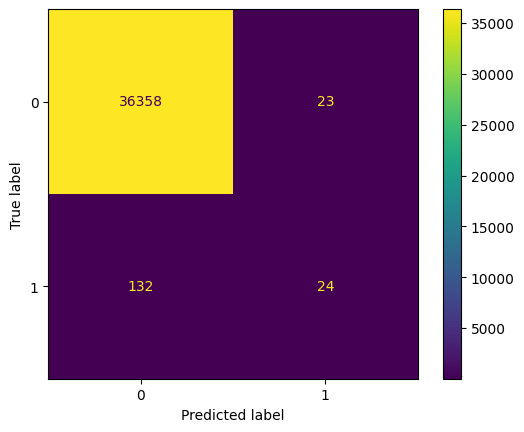

In [24]:
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred_binary)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1 Score:', f1)
print('AUC:', auc)


ConfusionMatrixDisplay(confusion).plot()

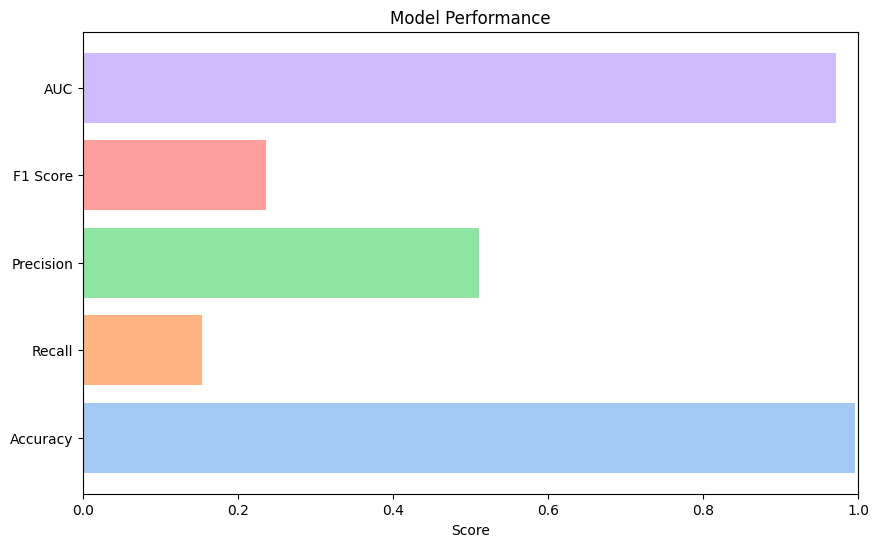

In [25]:
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC']
values = [accuracy, recall, precision, f1, auc]
colors = sns.color_palette('pastel', len(metrics))

plt.figure(figsize=(10, 6))
plt.barh(metrics, values, color=colors)
plt.xlabel('Score')
plt.title('Model Performance')
plt.xlim(0, 1)
plt.show()

In [28]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

# Compute precision and recall values
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# Calculate the area under the precision-recall curve (PRAUC)
prauc = auc(recall, precision)

print('PRAUC:', prauc)

ap = average_precision_score(y_test, y_pred)
print('average_precision_score', ap)

PRAUC: 0.3248295132476294
average_precision_score 0.3268208539548043


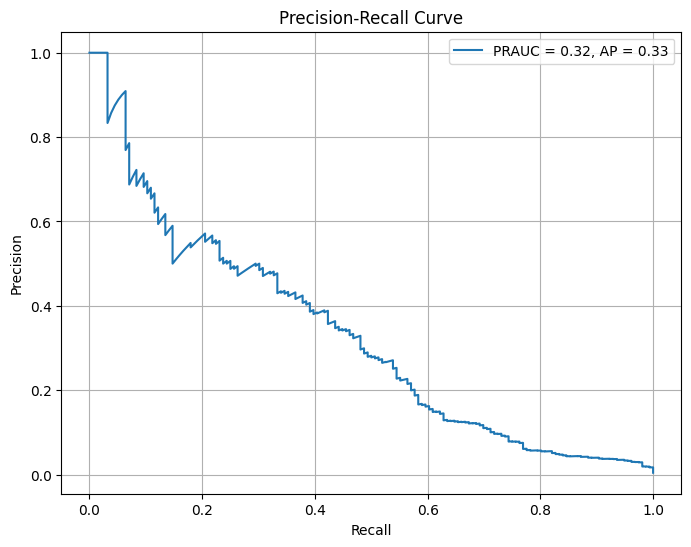

In [29]:
# Calculate the Average Precision (AP) to display in the plot
ap = average_precision_score(y_test, y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PRAUC = {prauc:.2f}, AP = {ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

In [30]:
importance = pd.DataFrame({'feature': x_train.columns, 'importance': gbm.feature_importance()})
importance = importance.sort_values('importance', ascending=False)
print(importance)

                        feature  importance
19          net_working_capital         840
22                 equity_ratio         716
1                         STInt         683
20                   debt_ratio         645
8                     sizelevel         639
17                  quick_ratio         635
10                          m2b         604
15              DTDmedianNonFin         579
26               asset_turnover         571
32            price_to_earnings         559
30        day_sales_outstanding         555
29         receivables_turnover         552
2                      dtdlevel         541
27           inventory_turnover         538
6                    ni2talevel         496
23       cashflow_to_debt_ratio         486
35           gross_margin_ratio         485
28            days_in_inventory         478
16                current_ratio         477
4                liqnonfinlevel         475
11                        sigma         463
25             return_on_assets 

c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


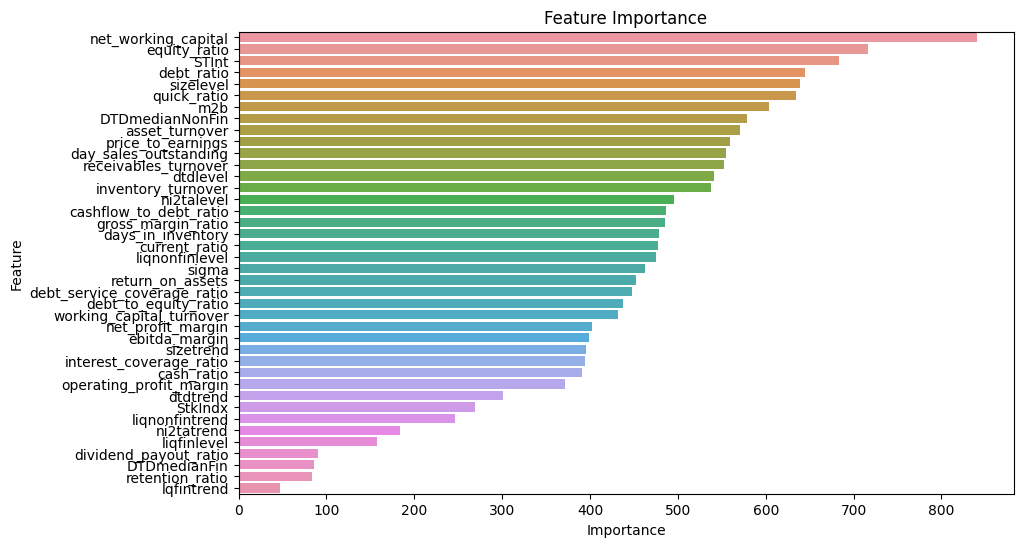

In [31]:
feature_importance = gbm.feature_importance()
features = x_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importance')
plt.show()

c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

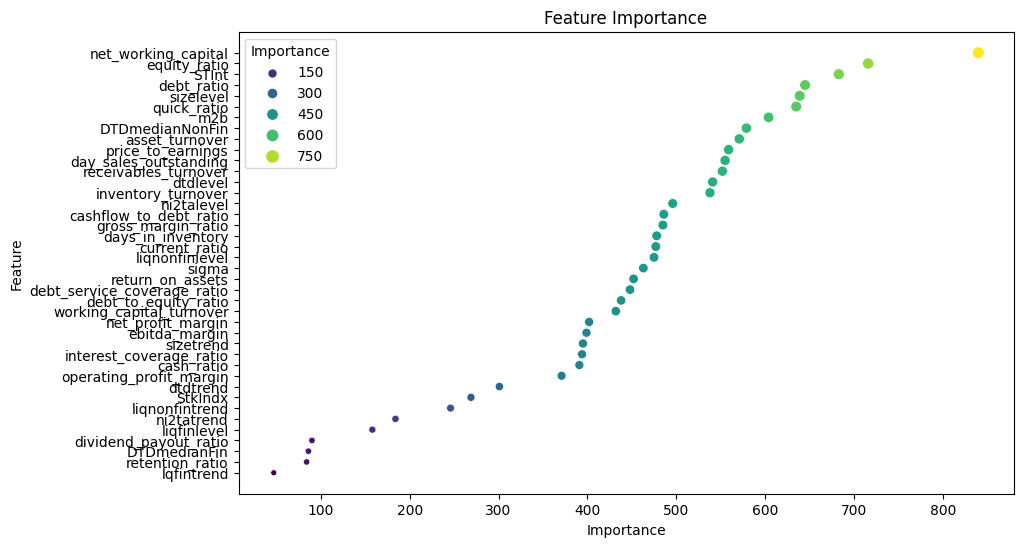

In [32]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False), size='Importance', hue='Importance', palette='viridis')
plt.title('Feature Importance')
plt.show()

In [36]:
#Precision OPTIMIZED
results = pd.DataFrame({'Recall': [recall], 'Precision': [precision], 'F1 Score': [f1], 'AUC': [auc]})
results.to_csv('LGB_all_factors_results_aucoptimized.csv', index=False)

best_params_df = pd.DataFrame(best_params, index=[0])
best_params_df.to_csv('best_params_lgb_allfactorsaucoptimized.csv', index=False)

gbm.save_model('model_lgb_allfactors_aucoptimized.txt')

Load one model and Plot performances

Accuracy: 0.9957577250458439
Recall: 0.15384615384615385
Precision: 0.5106382978723404
F1 Score: 0.23645320197044337
AUC: 0.9713426422216724


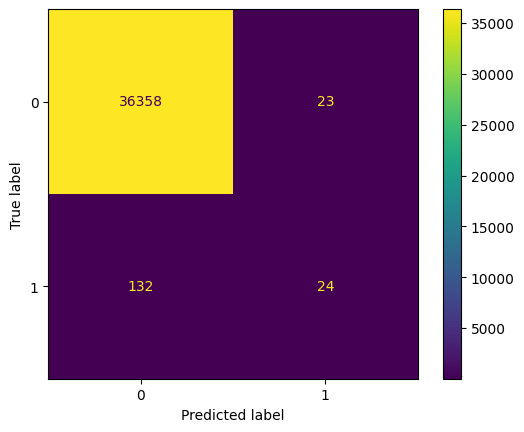

In [37]:
path_to_model = "model_lgb_allfactorsaucoptimized.txt"
gbm = lgb.Booster(model_file=path_to_model)

y_pred = gbm.predict(x_test)
y_pred_binary = np.round(y_pred)

accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred_binary)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1 Score:', f1)
print('AUC:', auc)

ConfusionMatrixDisplay(confusion).plot()

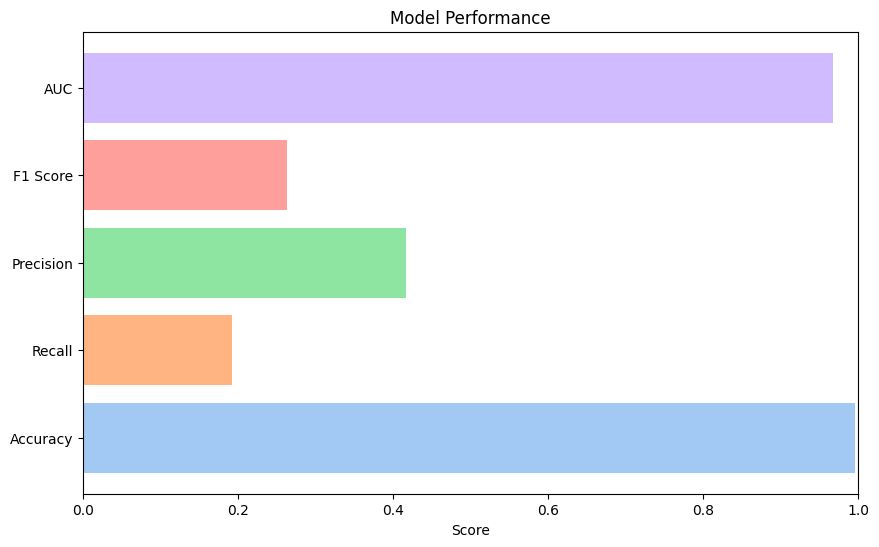

In [ ]:
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC']
values = [accuracy, recall, precision, f1, auc]
colors = sns.color_palette('pastel', len(metrics))

plt.figure(figsize=(10, 6))
plt.barh(metrics, values, color=colors)
plt.xlabel('Score')
plt.title('Model Performance')
plt.xlim(0, 1)
plt.show()

In [ ]:
importance = pd.DataFrame({'feature': x_train.columns, 'importance': gbm.feature_importance()})
importance = importance.sort_values('importance', ascending=False)
print(importance)

                        feature  importance
1                         STInt         756
19          net_working_capital         748
8                     sizelevel         728
22                 equity_ratio         724
29         receivables_turnover         700
20                   debt_ratio         685
4                liqnonfinlevel         656
26               asset_turnover         642
10                          m2b         631
17                  quick_ratio         611
35           gross_margin_ratio         608
30        day_sales_outstanding         592
2                      dtdlevel         584
27           inventory_turnover         577
16                current_ratio         568
6                    ni2talevel         561
15              DTDmedianNonFin         554
38  debt_service_coverage_ratio         539
23       cashflow_to_debt_ratio         536
39      interest_coverage_ratio         530
21         debt_to_equity_ratio         520
18                   cash_ratio 

c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


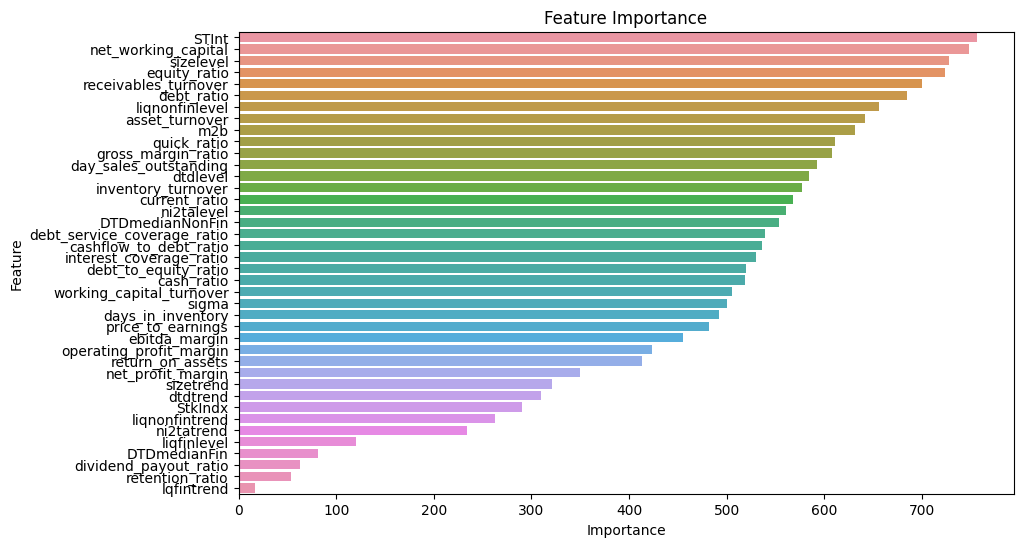

In [ ]:
feature_importance = gbm.feature_importance()
features = x_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importance')
plt.show()

c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

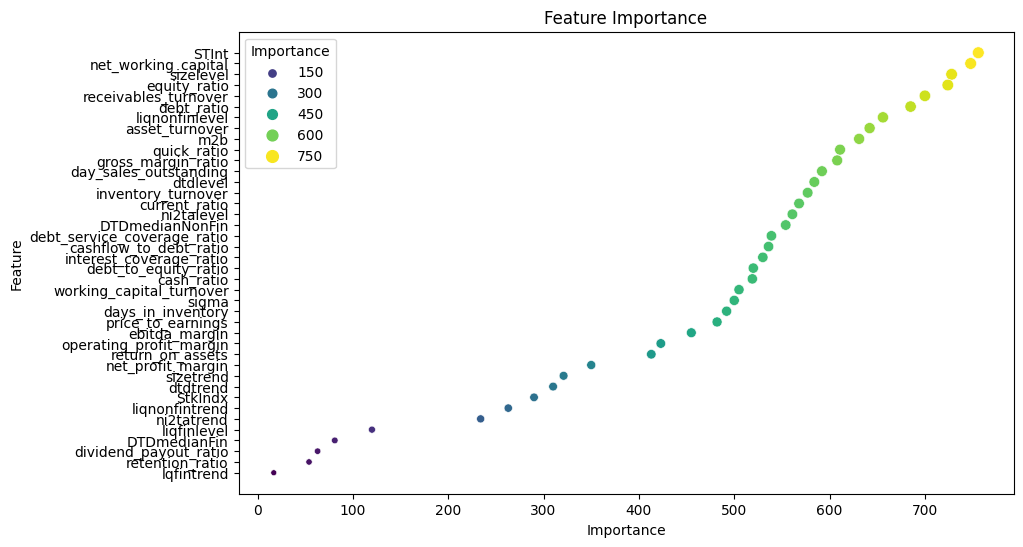

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False), size='Importance', hue='Importance', palette='viridis')
plt.title('Feature Importance')
plt.show()

Load 3 models and compare performances


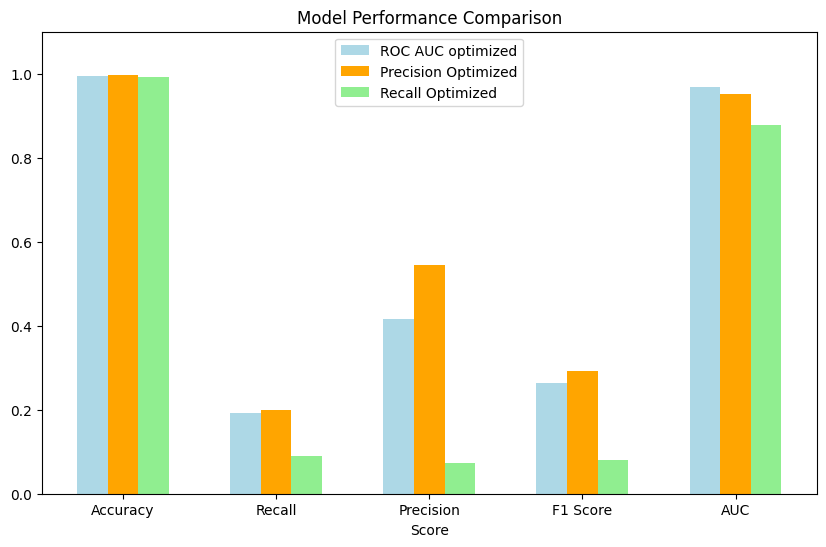

c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

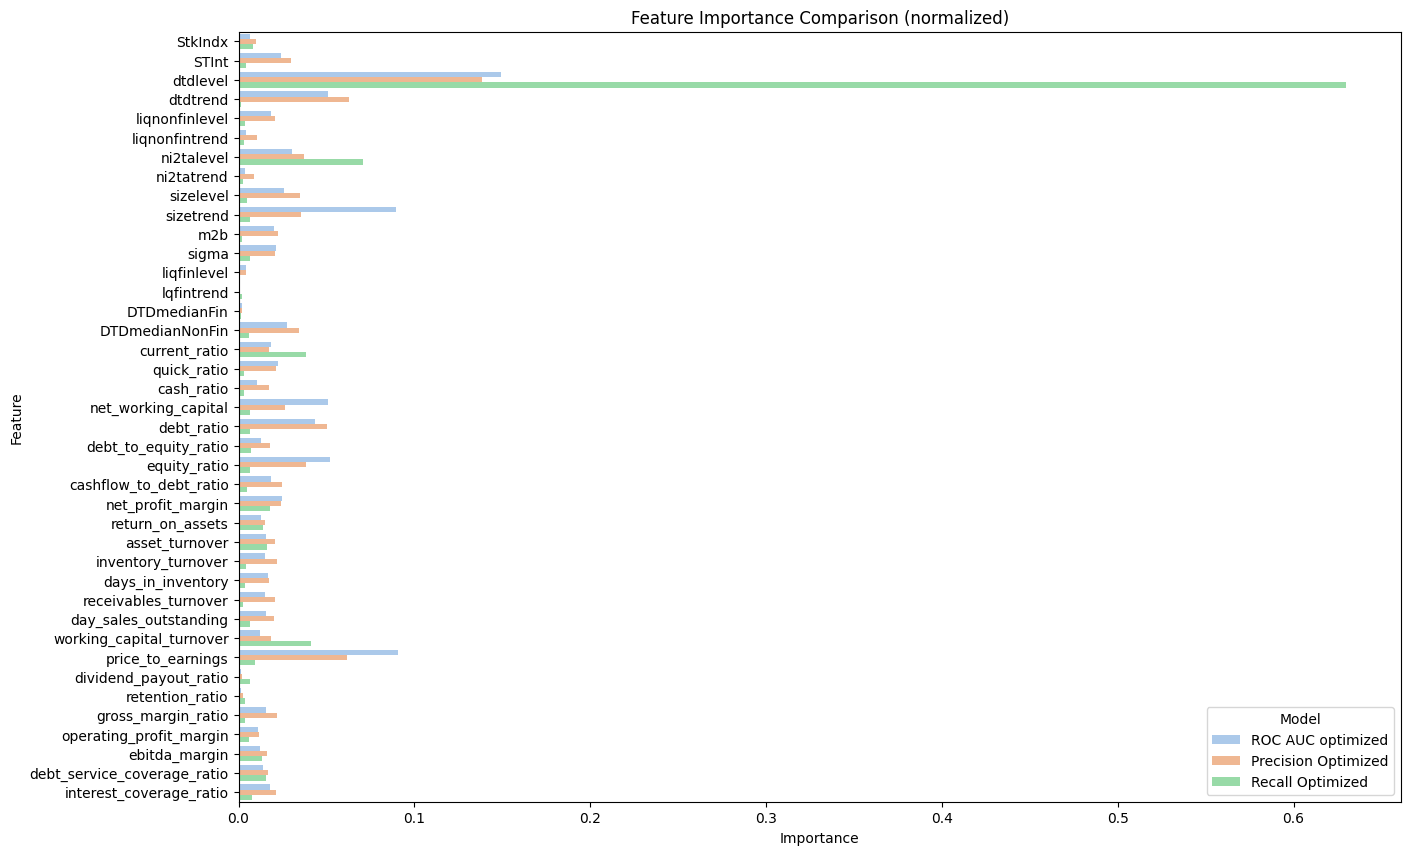

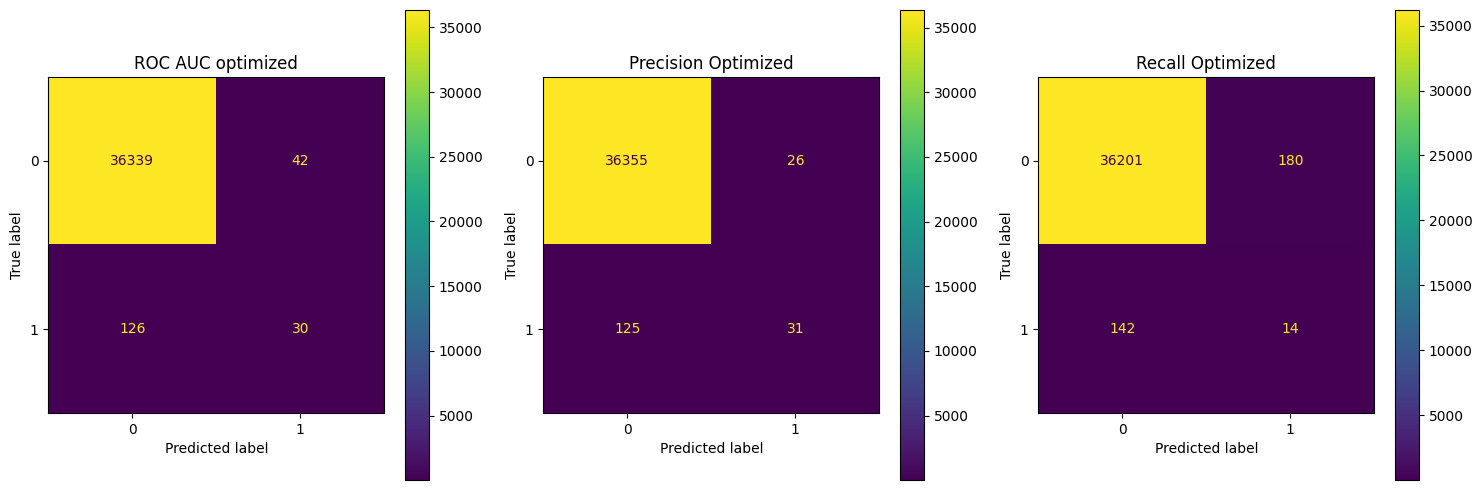

In [ ]:
# Load the models
bst1 = lgb.Booster(model_file= 'model_lgb_allfactors_aucoptimized.txt')
bst2 = lgb.Booster(model_file= 'model_lgb_allfactors_precisionoptimized.txt')
bst3 = lgb.Booster(model_file= 'model_lgb_allfactors_recalloptimized.txt')

# Predict the test data
y_pred1 = bst1.predict(x_test)
y_pred2 = bst2.predict(x_test)
y_pred3 = bst3.predict(x_test)

# Calculate the metrics
accuracy1 = accuracy_score(y_test, np.round(y_pred1))
recall1 = recall_score(y_test, np.round(y_pred1))
precision1 = precision_score(y_test, np.round(y_pred1))
f1_1 = f1_score(y_test, np.round(y_pred1))
auc1 = roc_auc_score(y_test, y_pred1)

accuracy2 = accuracy_score(y_test, np.round(y_pred2))
recall2 = recall_score(y_test, np.round(y_pred2))
precision2 = precision_score(y_test, np.round(y_pred2))
f1_2 = f1_score(y_test, np.round(y_pred2))
auc2 = roc_auc_score(y_test, y_pred2)

accuracy3 = accuracy_score(y_test, np.round(y_pred3))
recall3 = recall_score(y_test, np.round(y_pred3))
precision3 = precision_score(y_test, np.round(y_pred3))
f1_3 = f1_score(y_test, np.round(y_pred3))
auc3 = roc_auc_score(y_test, y_pred3)

metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC']
values1 = [accuracy1, recall1, precision1, f1_1, auc1]
values2 = [accuracy2, recall2, precision2, f1_2, auc2]
values3 = [accuracy3, recall3, precision3, f1_3, auc3]

x = np.arange(len(metrics))

plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, values1, 0.2, color='lightblue', label='ROC AUC optimized')
plt.bar(x, values2, 0.2, color='orange', label='Precision Optimized')
plt.bar(x + 0.2, values3, 0.2, color='lightgreen', label='Recall Optimized')
plt.xticks(x, metrics)
plt.xlabel('Score')
plt.title('Model Performance Comparison')
plt.ylim(0, 1.1)
plt.legend()
plt.show()

importance1 = bst1.feature_importance(importance_type='gain')
importance2 = bst2.feature_importance(importance_type='gain')
importance3 = bst3.feature_importance(importance_type='gain')

# Normalize the feature importance
importance1 = importance1 / sum(importance1)
importance2 = importance2 / sum(importance2)
importance3 = importance3 / sum(importance3)

# # Plot the feature importance
importance_df = pd.DataFrame({'Feature': x_test.columns, 'ROC AUC optimized': importance1, 'Precision Optimized': importance2, 'Recall Optimized': importance3})

importance_df = importance_df.melt('Feature', var_name='Model', value_name='Importance')

plt.figure(figsize=(15, 10))
sns.barplot(x='Importance', y='Feature', hue='Model', data=importance_df, palette='pastel')
plt.title('Feature Importance Comparison (normalized)')
plt.show()

# Calculate the confusion matrices
confusion1 = confusion_matrix(y_test, np.round(y_pred1))
confusion2 = confusion_matrix(y_test, np.round(y_pred2))
confusion3 = confusion_matrix(y_test, np.round(y_pred3))

# Plot the confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ConfusionMatrixDisplay(confusion1).plot(ax=axes[0], cmap='viridis')
axes[0].set_title('ROC AUC optimized')

ConfusionMatrixDisplay(confusion2).plot(ax=axes[1], cmap='viridis')
axes[1].set_title('Precision Optimized')

ConfusionMatrixDisplay(confusion3).plot(ax=axes[2], cmap='viridis')
axes[2].set_title('Recall Optimized')

plt.tight_layout()
plt.show()

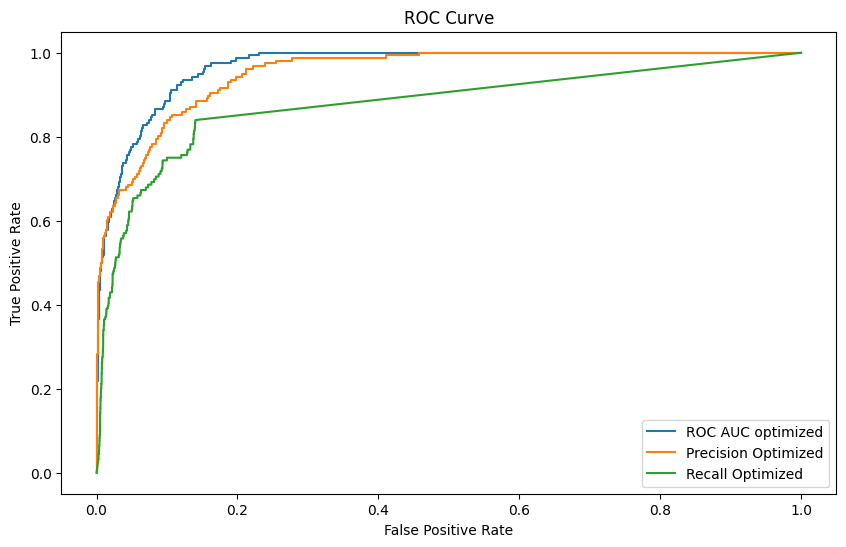

In [ ]:
fpr1, tpr1, _ = roc_curve(y_test, y_pred1)
fpr2, tpr2, _ = roc_curve(y_test, y_pred2)
fpr3, tpr3, _ = roc_curve(y_test, y_pred3)

plt.figure(figsize=(10, 6))
plt.plot(fpr1, tpr1, label='ROC AUC optimized')
plt.plot(fpr2, tpr2, label='Precision Optimized')
plt.plot(fpr3, tpr3, label='Recall Optimized')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

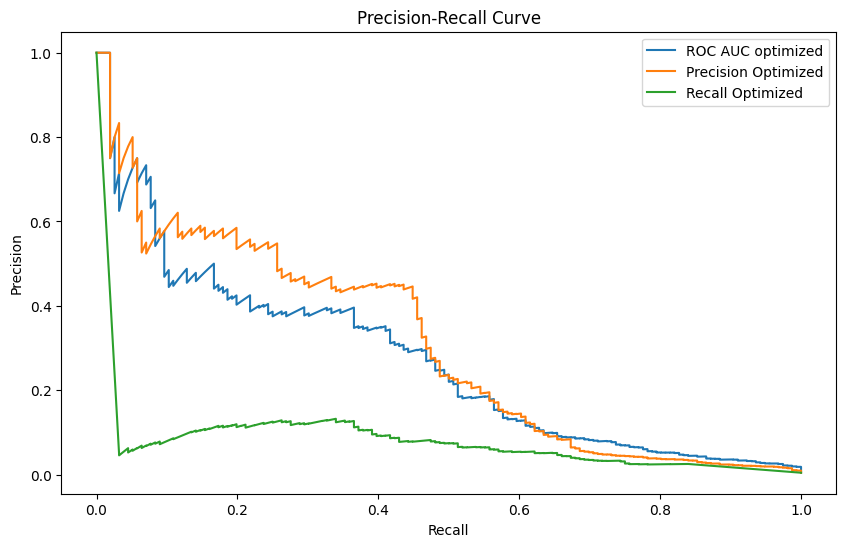

In [ ]:
precision1, recall1, _ = precision_recall_curve(y_test, y_pred1)
precision2, recall2, _ = precision_recall_curve(y_test, y_pred2)
precision3, recall3, _ = precision_recall_curve(y_test, y_pred3)

plt.figure(figsize=(10, 6))
plt.plot(recall1, precision1, label='ROC AUC optimized')
plt.plot(recall2, precision2, label='Precision Optimized')
plt.plot(recall3, precision3, label='Recall Optimized')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

Model l
Feature: 0
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7
Repeat:8
Repeat:9
Feature: 1
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7
Repeat:8
Repeat:9
Feature: 2
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7
Repeat:8
Repeat:9
Feature: 3
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7
Repeat:8
Repeat:9
Feature: 4
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7
Repeat:8
Repeat:9
Feature: 5
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7
Repeat:8
Repeat:9
Feature: 6
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7
Repeat:8
Repeat:9
Feature: 7
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7
Repeat:8
Repeat:9
Feature: 8
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7
Repeat:8
Repeat:9
Feature: 9
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7


c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

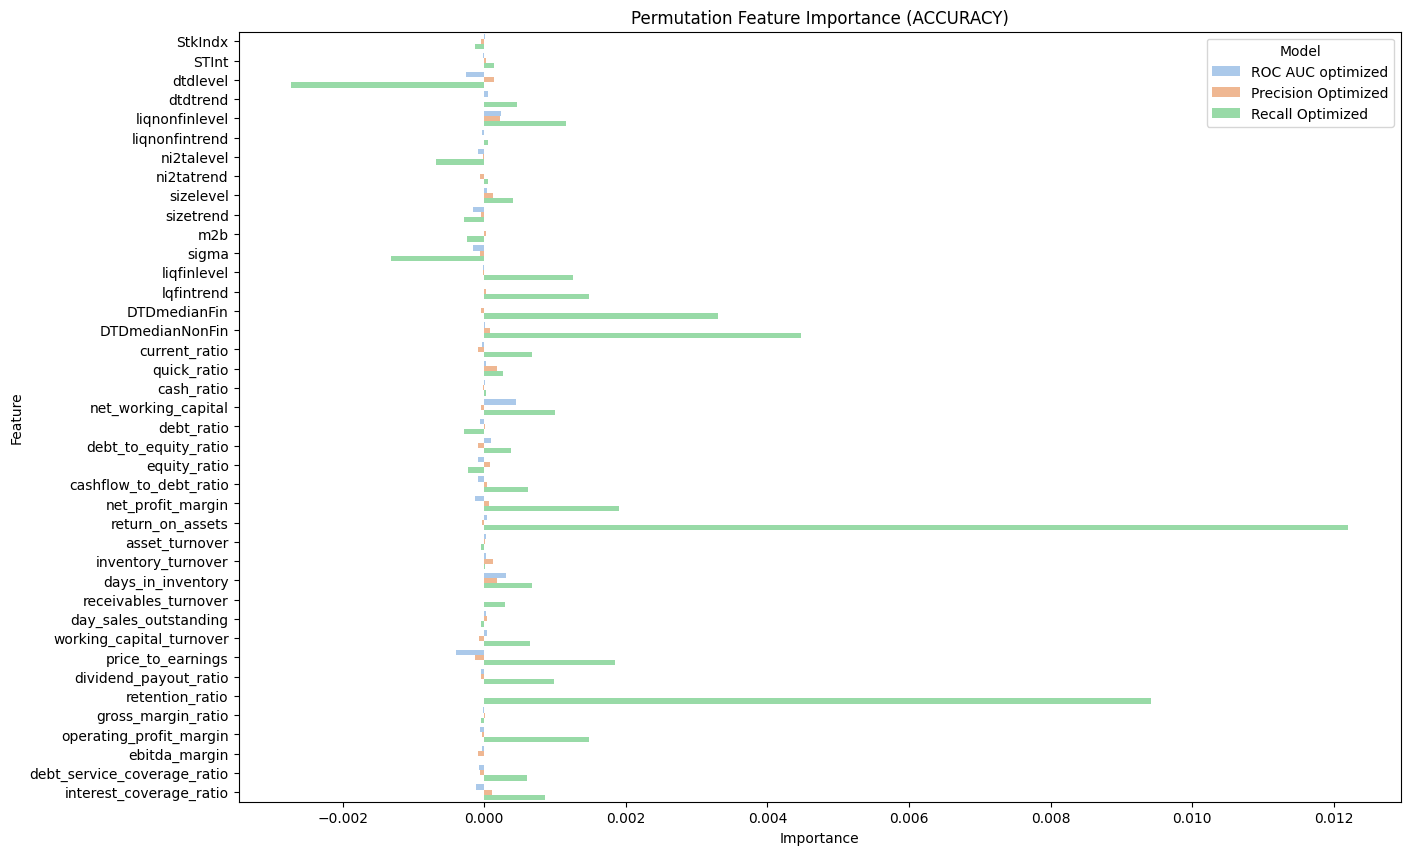

In [ ]:
# BASED ON ACCURACY
def permutation_importance(model, X, y, scoring, n_repeats, random_state):
    baseline_score = scoring(y, np.round(model.predict(X)))
    scores = np.zeros((X.shape[1], n_repeats))
    rng = np.random.RandomState(random_state)
    
    for feature in range(X.shape[1]):
        print("Feature: " + str(feature))
        X_permuted = X.copy()
        for repeat in range(n_repeats):
            print("Repeat:" + str(repeat))
            X_permuted.iloc[:, feature] = rng.permutation(X_permuted.iloc[:, feature])
            score = scoring(y, np.round(model.predict(X_permuted)))
            scores[feature, repeat] = baseline_score - score
    
    return scores

print("Model l")
perm_importance1 = permutation_importance(bst1, x_test, y_test, accuracy_score, n_repeats=10, random_state=42)
print("Model 3")
perm_importance2 = permutation_importance(bst2, x_test, y_test, accuracy_score, n_repeats=10, random_state=42)
print("Model 3")
perm_importance3 = permutation_importance(bst3, x_test, y_test, accuracy_score, n_repeats=10, random_state=42)

perm_importance_df = pd.DataFrame({'Feature': x_test.columns, 'ROC AUC optimized': np.mean(perm_importance1, axis=1), 'Precision Optimized': np.mean(perm_importance2, axis=1), 'Recall Optimized': np.mean(perm_importance3, axis=1)})

perm_importance_df = perm_importance_df.melt('Feature', var_name='Model', value_name='Importance')

plt.figure(figsize=(15, 10))
sns.barplot(x='Importance', y='Feature', hue='Model', data=perm_importance_df, palette='pastel')
plt.title('Permutation Feature Importance (ACCURACY)')
plt.show()

Model l
Model 3
Model 3


c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

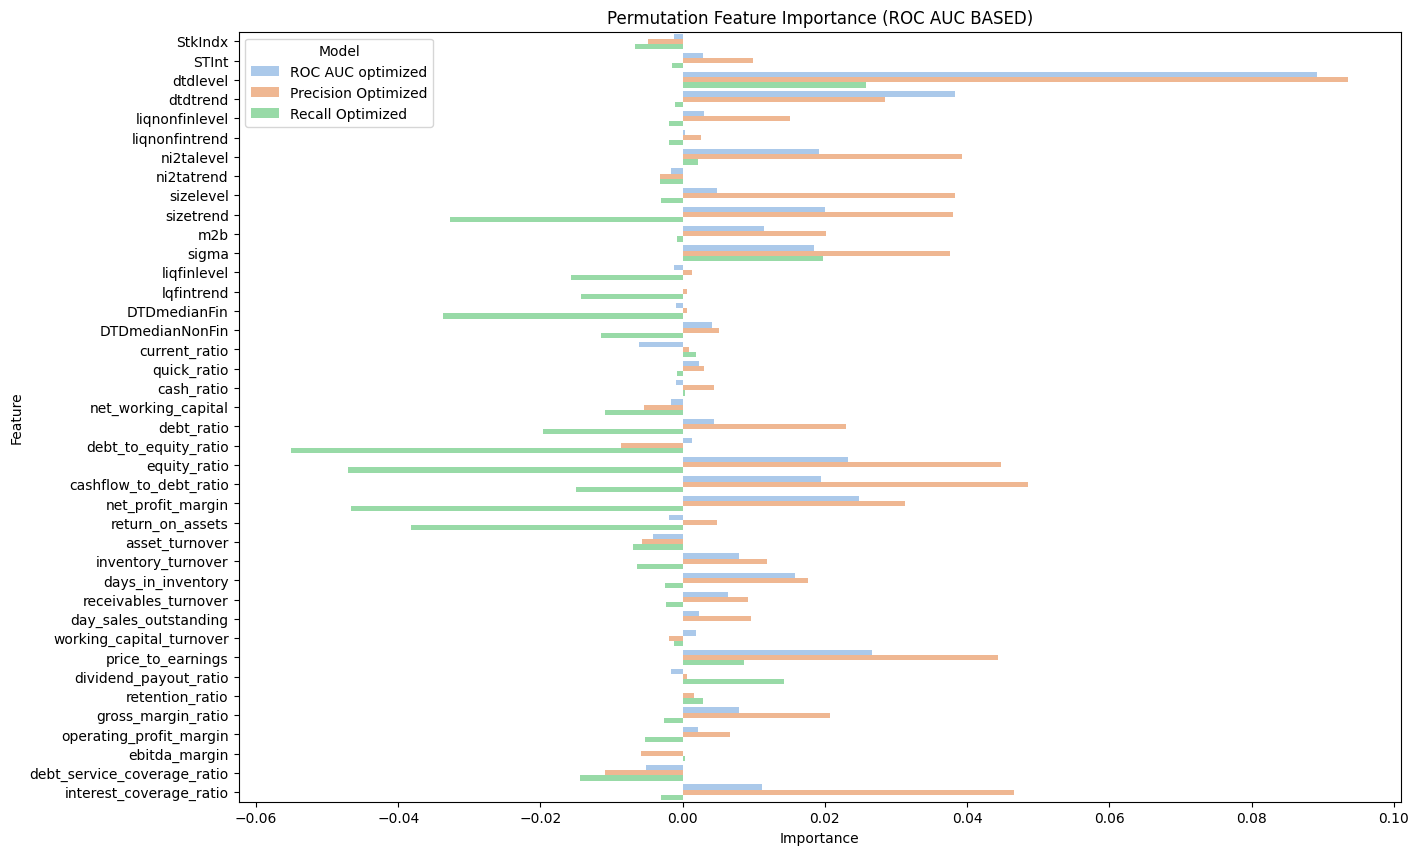

In [ ]:
# BASED ON ROC AUC
def permutation_importance(model, X, y, scoring, n_repeats, random_state):
    baseline_score = scoring(y, np.round(model.predict(X)))
    scores = np.zeros((X.shape[1], n_repeats))
    rng = np.random.RandomState(random_state)
    
    for feature in range(X.shape[1]):
        X_permuted = X.copy()
        for repeat in range(n_repeats):
            X_permuted.iloc[:, feature] = rng.permutation(X_permuted.iloc[:, feature])
            score = scoring(y, np.round(model.predict(X_permuted)))
            scores[feature, repeat] = baseline_score - score
    
    return scores

print("Model l")
perm_importance1 = permutation_importance(bst1, x_test, y_test, roc_auc_score, n_repeats=10, random_state=42)
print("Model 3")
perm_importance2 = permutation_importance(bst2, x_test, y_test, roc_auc_score, n_repeats=10, random_state=42)
print("Model 3")
perm_importance3 = permutation_importance(bst3, x_test, y_test, roc_auc_score, n_repeats=10, random_state=42)

perm_importance_df = pd.DataFrame({'Feature': x_test.columns, 'ROC AUC optimized': np.mean(perm_importance1, axis=1), 'Precision Optimized': np.mean(perm_importance2, axis=1), 'Recall Optimized': np.mean(perm_importance3, axis=1)})

perm_importance_df = perm_importance_df.melt('Feature', var_name='Model', value_name='Importance')

plt.figure(figsize=(15, 10))
sns.barplot(x='Importance', y='Feature', hue='Model', data=perm_importance_df, palette='pastel')
plt.title('Permutation Feature Importance (ROC AUC BASED)')
plt.show()